In [3]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from replaybuffer import ReplayBuffer

In [4]:
#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

#Create random agent
Random_Agent = RandomAgent(pendulum)

In [5]:
heuristic_agent = HeuristicPendulumAgent(pendulum)

In [6]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [7]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99

In [16]:
torch.manual_seed(-1)

network  = QNetwork().to(device) # critic
memory = ReplayBuffer(max_size=BUFFER_SIZE)

In [17]:
#target_actor = HeuristicPendulumAgent(pendulum).to(device)

q_optimizer  = optim.Adam(network.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [18]:
agent = heuristic_agent

In [70]:
current_state = deepcopy(pendulum.reset()[0])

ep_reward = 0.
ep_q_value = 0.
step = 0

# collect experience
for i in range(MAX_IT):
    # how many iterations??
    action = heuristic_agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)

    memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

    
    # TODO: buffer_start = ??
    if memory.count() > 128:
        # sample a batch of transitions from the replay buffer
        # TODO: sample random from 0 to 200??
        #indices = np.random.randint(0, 200, nr_of_samples)
        state_batch, action_batch, reward_batch, next_state_batch, trunc = memory.sample_transition(128)

In [128]:
targets = []
q_state = []
loss = 0

state = torch.FloatTensor(state_batch).to(device)
action = torch.FloatTensor([action_batch]).to(device)
reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
trunc = torch.Tensor([np.float32(trunc)]).unsqueeze(1).to(device)
next_state = torch.FloatTensor(next_state_batch).to(device)

In [96]:
st = state.T

In [91]:
action_next_state = agent.compute_action(state = next_state.T) # np

In [105]:
state

tensor([[-7.7090e-01, -6.3696e-01,  2.1890e-01],
        [ 6.8965e-01,  7.2415e-01,  1.3795e+00],
        [ 9.8471e-01, -1.7418e-01, -3.0138e-01],
        [ 9.4377e-01, -3.3060e-01, -3.4552e-01],
        [ 8.6734e-01, -4.9772e-01, -5.1255e-01],
        [ 9.8891e-01,  1.4853e-01, -1.3380e+00],
        [ 9.9703e-01, -7.7075e-02,  8.8208e-01],
        [ 9.7866e-01, -2.0549e-01,  9.2024e-01],
        [-8.0233e-01,  5.9688e-01,  6.5771e+00],
        [ 9.7605e-01, -2.1752e-01, -4.9807e-02],
        [-1.1251e-01,  9.9365e-01,  3.6988e+00],
        [ 9.9918e-01,  4.0503e-02, -1.8291e-01],
        [-9.7453e-01, -2.2425e-01,  7.7753e+00],
        [ 9.3330e-01,  3.5909e-01,  2.4884e-01],
        [ 4.4500e-01,  8.9553e-01, -5.9601e+00],
        [ 7.5749e-01, -6.5285e-01,  2.0845e+00],
        [ 9.9384e-01, -1.1078e-01, -1.2842e-02],
        [ 2.7742e-01,  9.6075e-01,  2.7043e+00],
        [ 6.4275e-01,  7.6608e-01, -4.2168e+00],
        [-9.8681e-01,  1.6188e-01,  7.3562e+00],
        [ 7.1555e-01

In [115]:


# To compute the targets in each step, do not use the on-trajectory action, 
# but compute a new action according to the policy
network_input_state = torch.cat((state, action.T),1)

network_input_next_state = torch.cat((next_state, torch.Tensor([action_next_state]).T),1)
with torch.no_grad():
    # network_input_next_state or network_input_state
    q_next = network(network_input_next_state) # should not be differentiated 

q_state.append([q_next]) # no grad??

target_state = reward + GAMMA * q_next # the last update in each episode should use q = 0 ?
#targets.append(target_state)

q = network(network_input_state)
#q_state.append(q)



q_optimizer.zero_grad()
q_loss = MSE(target_state, q)
q_loss.backward()
q_optimizer.step()
q_loss.item()

13542.1875

In [19]:
def onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, agent, gamma, network, iter):

    targets = []
    q_state = []
    loss = 0

    state = torch.FloatTensor(state_batch).to(device)
    action = torch.FloatTensor([action_batch]).to(device)
    reward = torch.FloatTensor(reward_batch).unsqueeze(1).to(device) #.unsqueeze(1)
    trunc = torch.Tensor([np.float32(trunc_batch)]).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state_batch).to(device)
    
    action_next_state = agent.compute_action(state = next_state.T) # np

    # To compute the targets in each step, do not use the on-trajectory action, 
    # but compute a new action according to the policy
    network_input_state = torch.cat((state, action.T),1)

    network_input_next_state = torch.cat((next_state, torch.Tensor([action_next_state]).T),1)
    with torch.no_grad():
        # network_input_next_state or network_input_state
        q_next = network(network_input_next_state) # should not be differentiated 

    q_state.append([q_next]) # no grad??
    if iter == MAX_IT:
        q_next = 0
    target_state = reward + gamma * q_next # the last update in each episode should use q = 0 ?
    targets.append(target_state)

    q = network(network_input_state)
    #q_state.append(q)

    q_optimizer.zero_grad()
    q_loss = MSE(target_state, q)
    q_loss.backward()
    q_optimizer.step()

    return q_loss


    # for i in range(BATCH_SIZE):

        

    #     action_next_state = agent.compute_action(state = next_state) # np

    #     # To compute the targets in each step, do not use the on-trajectory action, 
    #     # but compute a new action according to the policy
    #     network_input_state = torch.cat((state, action))

    #     network_input_next_state = torch.cat((next_state, torch.Tensor([action_next_state])))
    #     with torch.no_grad():
    #         # network_input_next_state or network_input_state
    #         q_next = network(network_input_next_state) # should not be differentiated 

    #     q_state.append([q_next]) # no grad??

    #     target_state = reward + gamma * q_next # the last update in each episode should use q = 0 ?
    #     targets.append(target_state)

    #     q = network(network_input_state)
    #     q_state.append(q)

    #     loss += MSE(target_state, q)

    

In [20]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
nr_of_samples = 128
buffer_start = 200


In [21]:
memory.count() 

0

In [22]:
q_losses = []
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        action = heuristic_agent.compute_action(state = current_state)
        transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(transformed_action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        
        # TODO: buffer_start = ??
        if memory.count() > buffer_start:
            # sample a batch of transitions from the replay buffer
            # TODO: sample random from 0 to 200??
            #indices = np.random.randint(0, 200, nr_of_samples)
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # 1-step TD-learning rule
            #TODO: the last update in each episode should use q = 0 !!
            q_loss = onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, heuristic_agent, GAMMA, network, i)
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    # plot_q.append([loss, episode])
    try:
        plot_q.append([q_loss.data, episode+1])
        q_losses.append(q_loss.item())
        print(q_loss.item())
    except:
        continue

    

  0%|          | 0/1000 [00:00<?, ?it/s]

15.873886108398438


  0%|          | 2/1000 [00:02<21:15,  1.28s/it]

16.104793548583984


  0%|          | 3/1000 [00:06<36:38,  2.20s/it]

14.94545841217041


  0%|          | 4/1000 [00:10<49:38,  2.99s/it]

22.35501480102539


  0%|          | 5/1000 [00:17<1:14:11,  4.47s/it]

27.279911041259766


  1%|          | 6/1000 [00:22<1:15:03,  4.53s/it]

28.30521011352539


  1%|          | 7/1000 [00:26<1:15:14,  4.55s/it]

27.29778480529785


  1%|          | 8/1000 [00:32<1:18:49,  4.77s/it]

32.20210266113281


  1%|          | 9/1000 [00:35<1:09:30,  4.21s/it]

36.24436569213867


  1%|          | 10/1000 [00:38<1:03:08,  3.83s/it]

51.83477020263672


  1%|          | 11/1000 [00:40<57:15,  3.47s/it]  

77.9458236694336


  1%|          | 12/1000 [00:43<53:42,  3.26s/it]

75.27435302734375


  1%|▏         | 13/1000 [00:46<52:58,  3.22s/it]

71.400390625


  1%|▏         | 14/1000 [00:49<51:34,  3.14s/it]

65.95379638671875


  2%|▏         | 15/1000 [00:52<51:30,  3.14s/it]

105.61853790283203


  2%|▏         | 16/1000 [00:55<49:54,  3.04s/it]

122.73568725585938


  2%|▏         | 17/1000 [00:58<49:44,  3.04s/it]

94.80192565917969


  2%|▏         | 18/1000 [01:01<49:51,  3.05s/it]

174.2257080078125


  2%|▏         | 19/1000 [01:04<49:18,  3.02s/it]

163.95985412597656


  2%|▏         | 20/1000 [01:07<49:07,  3.01s/it]

191.4556427001953


  2%|▏         | 21/1000 [01:11<54:04,  3.31s/it]

111.73435974121094


  2%|▏         | 22/1000 [01:15<58:21,  3.58s/it]

123.13772583007812


  2%|▏         | 23/1000 [01:20<1:02:09,  3.82s/it]

135.6075897216797


  2%|▏         | 24/1000 [01:24<1:03:58,  3.93s/it]

145.3988800048828


  2%|▎         | 25/1000 [01:28<1:06:00,  4.06s/it]

126.76419067382812


  3%|▎         | 26/1000 [01:33<1:08:28,  4.22s/it]

100.29142761230469


  3%|▎         | 27/1000 [01:37<1:08:27,  4.22s/it]

110.56979370117188


  3%|▎         | 28/1000 [01:41<1:07:27,  4.16s/it]

87.13386535644531


  3%|▎         | 29/1000 [01:45<1:04:15,  3.97s/it]

84.33275604248047


  3%|▎         | 30/1000 [01:48<1:00:34,  3.75s/it]

80.3915023803711


  3%|▎         | 31/1000 [01:51<56:50,  3.52s/it]  

60.95072555541992


  3%|▎         | 32/1000 [01:54<53:55,  3.34s/it]

46.47039031982422


  3%|▎         | 33/1000 [01:57<52:05,  3.23s/it]

66.57624053955078


  3%|▎         | 34/1000 [02:00<50:35,  3.14s/it]

32.33607482910156


  4%|▎         | 35/1000 [02:03<49:45,  3.09s/it]

26.565082550048828


  4%|▎         | 36/1000 [02:06<49:12,  3.06s/it]

30.541748046875


  4%|▎         | 37/1000 [02:09<49:24,  3.08s/it]

27.054792404174805


  4%|▍         | 38/1000 [02:12<49:22,  3.08s/it]

26.11598777770996


  4%|▍         | 39/1000 [02:15<49:12,  3.07s/it]

23.211013793945312


  4%|▍         | 40/1000 [02:18<49:23,  3.09s/it]

24.43695640563965


  4%|▍         | 41/1000 [02:21<49:52,  3.12s/it]

25.90569496154785


  4%|▍         | 42/1000 [02:25<50:59,  3.19s/it]

17.744041442871094


  4%|▍         | 43/1000 [02:28<52:01,  3.26s/it]

18.833711624145508


  4%|▍         | 44/1000 [02:31<52:28,  3.29s/it]

25.893224716186523


  4%|▍         | 45/1000 [02:35<53:17,  3.35s/it]

21.177139282226562


  5%|▍         | 46/1000 [02:38<53:32,  3.37s/it]

20.761701583862305


  5%|▍         | 47/1000 [02:42<53:20,  3.36s/it]

13.238447189331055


  5%|▍         | 48/1000 [02:45<53:21,  3.36s/it]

16.81821060180664


  5%|▍         | 49/1000 [02:48<53:13,  3.36s/it]

15.98425579071045


  5%|▌         | 50/1000 [02:52<53:03,  3.35s/it]

23.274818420410156


  5%|▌         | 51/1000 [02:55<54:40,  3.46s/it]

19.29065704345703


  5%|▌         | 52/1000 [02:59<54:16,  3.43s/it]

19.968442916870117


  5%|▌         | 53/1000 [03:02<53:45,  3.41s/it]

16.315406799316406


  5%|▌         | 54/1000 [03:05<53:51,  3.42s/it]

16.632661819458008


  6%|▌         | 55/1000 [03:09<53:26,  3.39s/it]

15.841520309448242


  6%|▌         | 56/1000 [03:12<53:14,  3.38s/it]

19.071468353271484


  6%|▌         | 57/1000 [03:16<54:10,  3.45s/it]

11.48790168762207


  6%|▌         | 58/1000 [03:20<1:00:14,  3.84s/it]

12.674907684326172


  6%|▌         | 59/1000 [03:24<58:31,  3.73s/it]  

13.86691665649414


  6%|▌         | 60/1000 [03:27<57:15,  3.66s/it]

23.469785690307617


  6%|▌         | 61/1000 [03:31<55:58,  3.58s/it]

14.824743270874023


  6%|▌         | 62/1000 [03:34<55:06,  3.53s/it]

14.98855972290039


  6%|▋         | 63/1000 [03:38<54:50,  3.51s/it]

15.19355297088623


  6%|▋         | 64/1000 [03:41<54:52,  3.52s/it]

17.51775550842285


  6%|▋         | 65/1000 [03:45<54:33,  3.50s/it]

15.381807327270508


  7%|▋         | 66/1000 [03:48<54:04,  3.47s/it]

16.396831512451172


  7%|▋         | 67/1000 [03:51<53:27,  3.44s/it]

17.06261444091797


  7%|▋         | 68/1000 [03:55<53:11,  3.42s/it]

21.661399841308594


  7%|▋         | 69/1000 [03:58<53:22,  3.44s/it]

14.516593933105469


  7%|▋         | 70/1000 [04:02<53:50,  3.47s/it]

14.46225643157959


  7%|▋         | 71/1000 [04:05<53:50,  3.48s/it]

19.28524398803711


  7%|▋         | 72/1000 [04:09<53:53,  3.48s/it]

20.0260009765625


  7%|▋         | 73/1000 [04:12<53:43,  3.48s/it]

14.957958221435547


  7%|▋         | 74/1000 [04:16<54:25,  3.53s/it]

17.797582626342773


  8%|▊         | 75/1000 [04:19<54:05,  3.51s/it]

11.896888732910156


  8%|▊         | 76/1000 [04:23<53:19,  3.46s/it]

16.954130172729492


  8%|▊         | 77/1000 [04:26<53:50,  3.50s/it]

17.229909896850586


  8%|▊         | 78/1000 [04:30<53:14,  3.46s/it]

13.610174179077148


  8%|▊         | 79/1000 [04:33<53:02,  3.46s/it]

15.533833503723145


  8%|▊         | 80/1000 [04:37<53:03,  3.46s/it]

16.677515029907227


  8%|▊         | 81/1000 [04:40<52:44,  3.44s/it]

10.265233993530273


  8%|▊         | 82/1000 [04:44<52:41,  3.44s/it]

16.319246292114258


  8%|▊         | 83/1000 [04:47<52:42,  3.45s/it]

11.899129867553711


  8%|▊         | 84/1000 [04:51<53:39,  3.51s/it]

16.244535446166992


  8%|▊         | 85/1000 [04:54<53:30,  3.51s/it]

19.825607299804688


  9%|▊         | 86/1000 [04:58<53:14,  3.49s/it]

15.446576118469238


  9%|▊         | 87/1000 [05:01<52:35,  3.46s/it]

16.426115036010742


  9%|▉         | 88/1000 [05:05<54:36,  3.59s/it]

10.691951751708984


  9%|▉         | 89/1000 [05:08<53:51,  3.55s/it]

12.33281421661377


  9%|▉         | 90/1000 [05:12<53:50,  3.55s/it]

14.247231483459473


  9%|▉         | 91/1000 [05:16<54:09,  3.58s/it]

20.229393005371094


  9%|▉         | 92/1000 [05:19<53:28,  3.53s/it]

8.896025657653809


  9%|▉         | 93/1000 [05:22<53:15,  3.52s/it]

18.987133026123047


  9%|▉         | 94/1000 [05:26<53:12,  3.52s/it]

14.664655685424805


 10%|▉         | 95/1000 [05:30<53:01,  3.52s/it]

17.13180160522461


 10%|▉         | 96/1000 [05:33<53:56,  3.58s/it]

14.488380432128906


 10%|▉         | 97/1000 [05:37<54:11,  3.60s/it]

17.234630584716797


 10%|▉         | 98/1000 [05:40<53:59,  3.59s/it]

12.951606750488281


 10%|▉         | 99/1000 [05:44<53:15,  3.55s/it]

14.08354377746582


 10%|█         | 100/1000 [05:47<53:18,  3.55s/it]

14.978923797607422


 10%|█         | 101/1000 [05:51<52:43,  3.52s/it]

15.850719451904297


 10%|█         | 102/1000 [05:54<52:22,  3.50s/it]

15.896254539489746


 10%|█         | 103/1000 [05:58<51:58,  3.48s/it]

16.753721237182617


 10%|█         | 104/1000 [06:01<51:56,  3.48s/it]

15.028824806213379


 10%|█         | 105/1000 [06:05<51:59,  3.49s/it]

16.857845306396484


 11%|█         | 106/1000 [06:08<51:59,  3.49s/it]

15.27716064453125


 11%|█         | 107/1000 [06:12<51:27,  3.46s/it]

12.072811126708984


 11%|█         | 108/1000 [06:15<51:19,  3.45s/it]

21.059066772460938


 11%|█         | 109/1000 [06:19<54:16,  3.66s/it]

16.66523551940918


 11%|█         | 110/1000 [06:23<56:06,  3.78s/it]

17.650236129760742


 11%|█         | 111/1000 [06:27<54:56,  3.71s/it]

20.34714126586914


 11%|█         | 112/1000 [06:30<53:19,  3.60s/it]

18.105865478515625


 11%|█▏        | 113/1000 [06:34<53:17,  3.60s/it]

16.686655044555664


 11%|█▏        | 114/1000 [06:37<53:19,  3.61s/it]

16.67806625366211


 12%|█▏        | 115/1000 [06:41<52:36,  3.57s/it]

16.520042419433594


 12%|█▏        | 116/1000 [06:44<51:55,  3.52s/it]

21.88878631591797


 12%|█▏        | 117/1000 [06:48<51:49,  3.52s/it]

17.8801212310791


 12%|█▏        | 118/1000 [06:51<51:54,  3.53s/it]

14.946656227111816


 12%|█▏        | 119/1000 [06:55<51:35,  3.51s/it]

15.348349571228027


 12%|█▏        | 120/1000 [06:58<51:29,  3.51s/it]

10.578010559082031


 12%|█▏        | 121/1000 [07:02<51:20,  3.50s/it]

14.731575012207031


 12%|█▏        | 122/1000 [07:05<50:46,  3.47s/it]

12.644697189331055


 12%|█▏        | 123/1000 [07:09<50:24,  3.45s/it]

11.88047981262207


 12%|█▏        | 124/1000 [07:12<51:01,  3.50s/it]

11.602479934692383


 12%|█▎        | 125/1000 [07:16<51:55,  3.56s/it]

22.60403060913086


 13%|█▎        | 126/1000 [07:20<52:10,  3.58s/it]

18.001705169677734


 13%|█▎        | 127/1000 [07:23<52:05,  3.58s/it]

12.385292053222656


 13%|█▎        | 128/1000 [07:27<51:54,  3.57s/it]

20.56658935546875


 13%|█▎        | 129/1000 [07:30<50:58,  3.51s/it]

13.940658569335938


 13%|█▎        | 130/1000 [07:33<50:26,  3.48s/it]

16.851280212402344


 13%|█▎        | 131/1000 [07:37<50:15,  3.47s/it]

14.822840690612793


 13%|█▎        | 132/1000 [07:41<50:38,  3.50s/it]

11.923323631286621


 13%|█▎        | 133/1000 [07:44<50:21,  3.48s/it]

13.875133514404297


 13%|█▎        | 134/1000 [07:47<49:42,  3.44s/it]

17.10424041748047


 14%|█▎        | 135/1000 [07:51<49:48,  3.45s/it]

14.17840576171875


 14%|█▎        | 136/1000 [07:54<49:26,  3.43s/it]

18.273391723632812


 14%|█▎        | 137/1000 [07:58<49:37,  3.45s/it]

14.12389087677002


 14%|█▍        | 138/1000 [08:01<49:58,  3.48s/it]

16.20404052734375


 14%|█▍        | 139/1000 [08:05<49:46,  3.47s/it]

10.388225555419922


 14%|█▍        | 140/1000 [08:08<49:17,  3.44s/it]

13.701395988464355


 14%|█▍        | 141/1000 [08:11<48:58,  3.42s/it]

11.992546081542969


 14%|█▍        | 142/1000 [08:15<49:05,  3.43s/it]

14.138492584228516


 14%|█▍        | 143/1000 [08:18<48:56,  3.43s/it]

16.34261131286621


 14%|█▍        | 144/1000 [08:22<49:23,  3.46s/it]

8.082511901855469


 14%|█▍        | 145/1000 [08:25<49:16,  3.46s/it]

9.192461013793945


 15%|█▍        | 146/1000 [08:29<49:14,  3.46s/it]

10.055914878845215


 15%|█▍        | 147/1000 [08:32<49:11,  3.46s/it]

14.594849586486816


 15%|█▍        | 148/1000 [08:36<49:21,  3.48s/it]

7.9319329261779785


 15%|█▍        | 149/1000 [08:39<48:42,  3.43s/it]

13.622260093688965


 15%|█▌        | 150/1000 [08:43<49:20,  3.48s/it]

15.395781517028809


 15%|█▌        | 151/1000 [08:46<49:02,  3.47s/it]

15.820493698120117


 15%|█▌        | 152/1000 [08:50<48:56,  3.46s/it]

12.970294952392578


 15%|█▌        | 153/1000 [08:53<50:02,  3.55s/it]

14.657610893249512


 15%|█▌        | 154/1000 [08:57<50:01,  3.55s/it]

13.990728378295898


 16%|█▌        | 155/1000 [09:00<49:54,  3.54s/it]

12.048272132873535


 16%|█▌        | 156/1000 [09:04<49:50,  3.54s/it]

15.516712188720703


 16%|█▌        | 157/1000 [09:07<49:17,  3.51s/it]

19.076932907104492


 16%|█▌        | 158/1000 [09:11<48:42,  3.47s/it]

12.074787139892578


 16%|█▌        | 159/1000 [09:14<48:52,  3.49s/it]

13.459598541259766


 16%|█▌        | 160/1000 [09:18<48:52,  3.49s/it]

13.294590950012207


 16%|█▌        | 161/1000 [09:22<52:38,  3.76s/it]

16.833696365356445


 16%|█▌        | 162/1000 [09:26<54:10,  3.88s/it]

12.407508850097656


 16%|█▋        | 163/1000 [09:30<52:36,  3.77s/it]

14.750870704650879


 16%|█▋        | 164/1000 [09:33<51:59,  3.73s/it]

14.649694442749023


 16%|█▋        | 165/1000 [09:38<56:13,  4.04s/it]

17.27906608581543


 17%|█▋        | 166/1000 [09:44<1:05:06,  4.68s/it]

17.901824951171875


 17%|█▋        | 167/1000 [09:50<1:08:53,  4.96s/it]

17.7364501953125


 17%|█▋        | 168/1000 [09:54<1:06:27,  4.79s/it]

20.222999572753906


 17%|█▋        | 169/1000 [10:00<1:07:50,  4.90s/it]

17.276771545410156


 17%|█▋        | 170/1000 [10:05<1:08:43,  4.97s/it]

16.032779693603516


 17%|█▋        | 171/1000 [10:09<1:06:05,  4.78s/it]

14.543542861938477


 17%|█▋        | 172/1000 [10:14<1:05:12,  4.73s/it]

13.235919952392578


 17%|█▋        | 173/1000 [10:18<1:02:16,  4.52s/it]

13.083955764770508


 17%|█▋        | 174/1000 [10:22<1:00:54,  4.42s/it]

12.33258056640625


 18%|█▊        | 175/1000 [10:27<1:04:36,  4.70s/it]

12.582460403442383


 18%|█▊        | 176/1000 [10:32<1:04:32,  4.70s/it]

18.911569595336914


 18%|█▊        | 177/1000 [10:37<1:05:30,  4.78s/it]

15.507452011108398


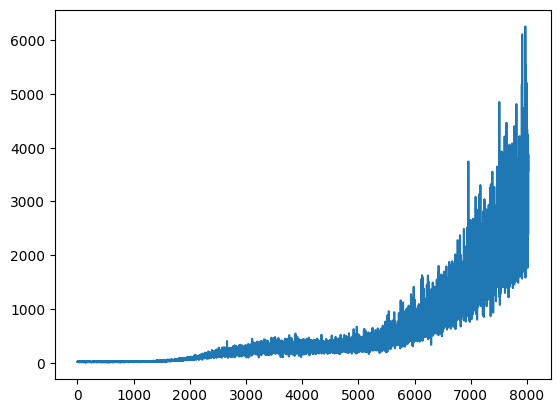

In [69]:
plt.plot(q_losses)

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

Text(0.5, 1.0, 'Q loss')

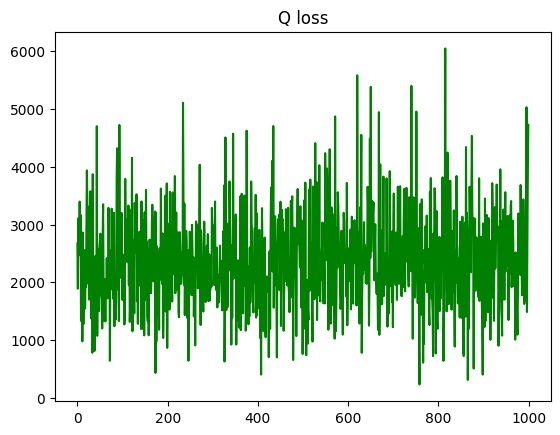

In [186]:
q = list(zip(*plot_q))
plt.plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
plt.title('Q loss')

In [12]:
i = 0
while i < MAX_IT:
    action = heuristic_agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)

    memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

    current_state = deepcopy(next_state)
    ep_reward += reward
    i += 1

NameError: name 'current_state' is not defined

[(array([0.97788984, 0.20912069, 0.18009238], dtype=float32),
  -1.0,
  -0.051627571543737774,
  array([0.9775334 , 0.2107805 , 0.03395293], dtype=float32),
  False),
 (array([ 0.95440036,  0.2985296 , -2.3184805 ], dtype=float32),
  1.0,
  -0.6334360689743704,
  array([ 0.9773568 ,  0.21159807, -1.7988373 ], dtype=float32),
  False)]